In [15]:
import bql
import numpy as np
from IPython.display import display, clear_output
import pandas as pd
import time 
import datetime
from ipywidgets import *
from bqplot import *
from bqplot.interacts import *

bq = bql.Service()
d = bq.data
f = bq.func
u = bq.univ

fi_idx = pd.read_excel('FixedIncome_IDX_universe_list.xlsx')['ID'].tolist()

In [16]:
# INPUTS ###############

index_to_replicate = 'HFRIFOF Index'

start_date = datetime.datetime(2004,12,31)
end_date = datetime.datetime(2018,12,31)

In [17]:
######################  MAIN  ######################

index_universe = [index_to_replicate] + fi_idx

# Get the the index currency
id_currency = d.crncy()

request = bql.Request(index_universe[0], {'CURRENCY': id_currency})
res = bq.execute(request)
idx_curr = list(res[0].df()['CURRENCY'])

criteria = id_currency == idx_curr[0]
filtered_univ = u.filter(u.list(fi_idx), criteria)

# Compute the correlation matrix

price = d.px_last(start = start_date, end = end_date, per = 'M', fill='prev', currency = 'USD')
price = (100*price)/f.first(price) # Normalize each data series as in Percentage Appreciation but adds an offset of 100 (SAME METHOD WHEN COMPARING TWO SERIES IN GP<GO> AND NORMALIZING)

# price = f.znav(f.pct_diff(f.zscore(price)))/100
# price = 1-f.cumprod(price + 1) #We calculate the z_score of the price and from that z_score we see the cumulative total return to get the correlation

base_price = f.value(price, u.list(index_universe[0]))
correlation = f.corr(base_price, price)
correlation = f.dropna(correlation, REMOVE_ID =True)['value']

request = bql.Request(filtered_univ, {'CORRELATION': correlation}, preferences={'currencycheck':'ignore'}) #There's an error with de currencies of these tickers. This way we "solve" the issue
res = bq.execute(request)
data_mat = res[0].df().reset_index()

# Sort by Correlation and filter with the index list that have the same currency as the index we want to replicate to avoid currency risks
filtered_data_mat = data_mat.sort_values(by = ['CORRELATION'], ascending = False)

# Get the cumulative performance of de zscore of the price of the filtered assets
filtered_assets = [index_universe[0]] + filtered_data_mat['ID'].tolist()

for i in range(len(filtered_assets)): #We're doing this to get the DF in a way that the columns are the assets and the rows months (in some cases it's difficult to make the monthly alineation, this is why we develop this code)
    request = bql.Request(filtered_assets[i], {filtered_assets[i]: price}, preferences={'currencycheck':'ignore'}) #There's an error with de currencies of these tickers. This way we "solve" the issue
    res = bq.execute(request)
    
    asset = res[0].df()
    asset = pd.DataFrame({filtered_assets[i]: asset[filtered_assets[i]].tolist(), 'DATE': asset['DATE'].tolist()}, index= list(range(len(asset))))
    
    year_list = pd.DatetimeIndex(asset['DATE']).year.tolist()
    month_list = pd.DatetimeIndex(asset['DATE']).month.tolist()
    date_list = []
    for j in range(len(year_list)):
        date_list += [str(year_list[j]) + '-' + str(month_list[j])]
    asset['aux_date'] = date_list    
    
    if i == 0:
        matrix = asset.copy(deep=True)
    else :
        asset = asset.drop(['DATE'], axis=1)
        matrix = pd.merge(matrix, asset, how='left', on=['aux_date', 'aux_date'])
        

aux_matrix = matrix[filtered_assets]

FIRST WE MEASUERE THE CORRELATIONS BETWEEN THE ASSETS AND THE INDEX AND FILTER FOR THE REST OF THE ANALYSIS BY TAKING THE INDEX/ASSETS WITH A POSITIVE CORRELATION ABOVE 70%

In [18]:
filtered_data_mat = filtered_data_mat[filtered_data_mat['CORRELATION']>=0.7]
filtered_assets = filtered_data_mat['ID'].tolist()+[index_to_replicate]
aux_matrix = aux_matrix[filtered_assets]

In [19]:
x_bar = filtered_data_mat['ID'].tolist()
y_bar = filtered_data_mat['CORRELATION'].tolist()

xs = OrdinalScale()
ys = LinearScale()
sc = ColorScale(mid=0.0)

bar = Bars(x=x_bar, y=y_bar, scales={'x': xs, 'y': ys, 'color': sc}, color=y_bar, padding=0.5)

#To put names it's necessary the attribute names and the scatter plot has it. in order to see only the bars, the opacity of the scatter is going to be 0
# Changing the marker as 
sc_x = LinearScale()
sc_y = LinearScale()

scatt = Scatter(x=x_bar, y=y_bar, names=np.array(y_bar), scales={'x': xs, 'y': ys})

xax = Axis(scale=xs, tick_rotate=-45)
yax = Axis(scale=ys, orientation='vertical', tick_format='0.0%', grid_lines='solid')

plot = Figure(marks=[bar, scatt], axes=[xax, yax])
plot.layout.width = '1500px'
plot

Figure(axes=[Axis(scale=OrdinalScale(), tick_rotate=-45), Axis(orientation='vertical', scale=LinearScale(), ti…

WE SEE THE CONNECTIONS BETWEEN THE ASSETS AND THE INDEX WITH THE DENDROGRAM OF THE CORRELATION MATRIX

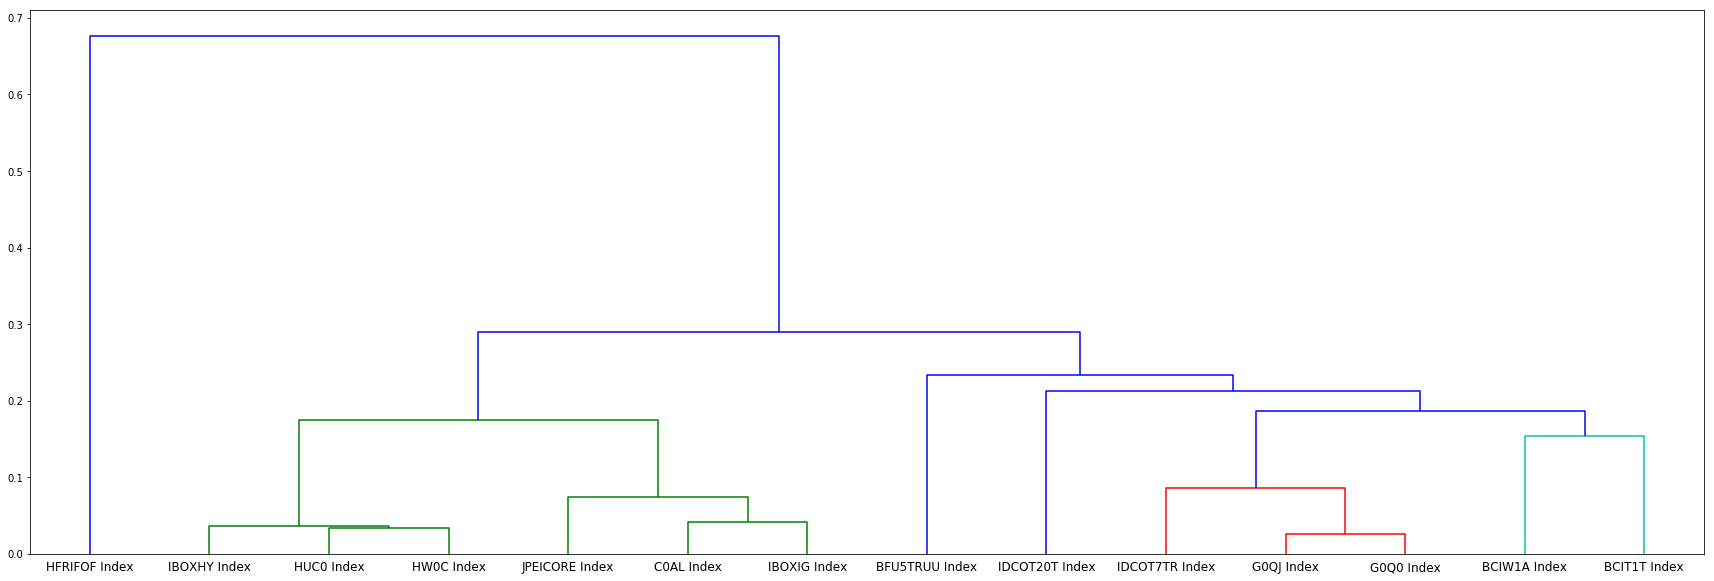

In [20]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

def correlDist(corr):
    dist = ((1-corr)/2)**0.5
    return dist

Correlations = aux_matrix.corr(method ='pearson')
Z = linkage(correlDist(Correlations))

max_d = 0.18

plt.figure(figsize=(30, 10), facecolor='w')
dendrogram(Z, labels = filtered_assets, color_threshold = max_d)
plt.show()

IN ORDER TO KNOW THE IMPORTANCE (WEIGHT) OF EACH ASSET AS A CHARACTERISTIC OF THE INDEX, WE PERFORM A LASSO REGRESSION (IN THIS CASE, WE DON'T USE A RIDGE REGRESSION BECAUSE THE DATA IS LESS CORRELATED)

In [21]:
from sklearn import linear_model

#We have to transform the data to give the correcto input for the ridge regression function
X = []
for i in range(len(aux_matrix)):
    X.append(np.array(aux_matrix.iloc[i][filtered_data_mat['ID'].tolist()].tolist()))
X = np.array(X)
y = np.array(aux_matrix[index_universe[0]])
#############

list_alphas = np.arange(0.0001, 0.5, 0.0001)
list_FI = filtered_data_mat['ID'].tolist()

weights = []
for coef_alpha in list_alphas:
    model = linear_model.Lasso(alpha=coef_alpha).fit(X,y)
    weights.append(model.coef_)
    
list_weights= []
for i in range(len(list_FI)):
    aux_weight = []
    for ii in range(len(list_alphas)):
        aux_weight += [weights[ii][i]]
    
    list_weights += [aux_weight]
    
    
# Calculate the area of the curve in absolute terms
ridge_area = []
for i in range(len(list_FI)):
    ridge_area += [abs(sum(list_weights[i]))]
    
ridge_area = np.array(ridge_area)

#We will use this data mat when generating the scores to rack the assets
ridge_area_data_mat = pd.DataFrame(data = {'ID': list_FI, 'Ridge': ridge_area})

C:\blp\BQuant\environments\bqnt-1.10.1\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [22]:
x_lg = LogScale()
y_sc = LinearScale()

line = Lines(x=-list_alphas, y=list_weights, scales={'x': x_lg, 'y': y_sc}, display_legend=True, labels=list_FI)

ax_x = Axis(scale=x_lg, label='Alpha')
ax_y = Axis(scale=y_sc, orientation='vertical', label = 'Pesos')

plot = Figure(marks=[line], axes=[ax_x, ax_y], legend_location='top-left')
plot.layout.width = '1500px'
plot

Figure(axes=[Axis(label='Alpha', scale=LogScale()), Axis(label='Pesos', orientation='vertical', scale=LinearSc…

FINALLY WE MAKE A PCA TO CONTRAST ALL THIS RESULT IN ORDER TO CONFIRM THE ASSET SELECTION

In [23]:
from sklearn.decomposition import PCA

# The first step is to apply the difference between the series of the assets and the index
aux_matrix2 = aux_matrix.copy(deep=True)
aux_matrix2 = aux_matrix2[list_FI]
for eq in list_FI:
    aux_matrix2[eq] = aux_matrix2[eq] - aux_matrix[index_universe[0]] 

#Then we have to transform the data as in the Ridge regression
X = []
for i in range(len(aux_matrix2)):
    X.append(np.array(aux_matrix2.iloc[i][list_FI].tolist()))
X = np.array(X)
#############

pca = PCA(n_components=len(list_FI))
pca.fit(X)

x_bar = ['PC']*len(list_FI)
for i in range(len(list_FI)):
    x_bar[i] = x_bar[i] + str(i+1)

xs = OrdinalScale()
ys = LinearScale()
sc = ColorScale(mid=0.0)

bar = Bars(x=x_bar, y=pca.explained_variance_ratio_, scales={'x': xs, 'y': ys, 'color': sc}, color=y_bar, padding=0.5)

#To put names it's necessary the attribute names and the scatter plot has it. in order to see only the bars, the opacity of the scatter is going to be 0
# Changing the marker as 
sc_x = OrdinalScale()
sc_y = LinearScale()

scatt = Scatter(x=x_bar, y=pca.explained_variance_ratio_, names=np.array(pca.explained_variance_ratio_), scales={'x': xs, 'y': ys})

xax = Axis(scale=xs)
yax = Axis(scale=ys, orientation='vertical', tick_format='0.0%', grid_lines='solid')

plot = Figure(marks=[bar, scatt], axes=[xax, yax], title = 'Varianza explicada')
plot.layout.width = '1500px'
plot

Figure(axes=[Axis(scale=OrdinalScale()), Axis(orientation='vertical', scale=LinearScale(), tick_format='0.0%')…

In [24]:
explained_components = []
for i in range(len(list_FI)):
    
    #It must invert the weights of each components because we're computing the spread between an asset and the index to replicate
    aux_inv_PC = 1/pca.components_[i]
    
    #Some values are close to inf, so we replace them with the next maximum of the array
    aux_inv_PC[aux_inv_PC == -np.inf] = 0
    aux_inv_PC[aux_inv_PC == np.inf] = 0
    aux_inv_PC[aux_inv_PC == 0] = max(aux_inv_PC)
    
    explained_components += [aux_inv_PC*pca.explained_variance_ratio_[i]]
    
total_explained_components = []    
for i in range(len(list_FI)):
    sum_cont = 0
    for ii in range(len(list_FI)):
        sum_cont += abs(explained_components[ii][i])
        
    total_explained_components += [sum_cont]

pca_mat = pd.DataFrame(data = {'ID': list_FI,'Explained PCA': total_explained_components})
pca_mat = pca_mat.sort_values(by=['Explained PCA'], ascending=False)
    
#Plot the significance of each asset

xs = OrdinalScale()
ys = LinearScale()
sc = ColorScale(mid=0.0)

bar = Bars(x=pca_mat['ID'].tolist(), y=pca_mat['Explained PCA'].tolist(), scales={'x': xs, 'y': ys, 'color': sc}, color=pca_mat['Explained PCA'].tolist(), padding=0.5)

#To put names it's necessary the attribute names and the scatter plot has it. in order to see only the bars, the opacity of the scatter is going to be 0
# Changing the marker as 
sc_x = OrdinalScale()
sc_y = LinearScale()

scatt = Scatter(x=pca_mat['ID'].tolist(), y=pca_mat['Explained PCA'].tolist(), names=np.array(pca_mat['Explained PCA'].tolist()), scales={'x': xs, 'y': ys})

xax = Axis(scale=xs, tick_rotate=-45)
yax = Axis(scale=ys, orientation='vertical', tick_format='0.0', grid_lines='solid')

plot = Figure(marks=[bar, scatt], axes=[xax, yax], title = 'Valor total de SUMA(Varianza explicada * peso CP) de cada variable')
plot.layout.width = '1500px'
plot

Figure(axes=[Axis(scale=OrdinalScale(), tick_rotate=-45), Axis(orientation='vertical', scale=LinearScale(), ti…

In [25]:
orig_pca_mat = pd.DataFrame(data = {'ID': list_FI,'PC1': pca.components_[0], 'PC2': pca.components_[1]})

sc_x = LinearScale()
sc_y = LinearScale()

scatt = Scatter(x=orig_pca_mat['PC1'].tolist(), y=orig_pca_mat['PC2'].tolist(), names=orig_pca_mat['ID'].tolist(), scales={'x': sc_x, 'y': sc_y}, apply_clip=False)

xax = Axis(scale=sc_x, label = 'PC1', )
yax = Axis(scale=sc_y, orientation='vertical', grid_lines='solid', label = 'PC2')

plot = Figure(marks=[scatt], axes=[xax, yax])
plot.layout.width = '1500px'
plot

Figure(axes=[Axis(label='PC1', scale=LinearScale()), Axis(label='PC2', orientation='vertical', scale=LinearSca…

CONSIDERING ALL THE INPUTS WE GET FROM THE STATISTICAL ANALYSIS, WE GENERATE A SCORE FOR EACH PART

In [26]:
from scipy.cluster.hierarchy import fcluster

score_stats_mat = filtered_data_mat.copy(deep = True)

#We've observed that the index HFRIFOF it should be in the cluster defined by the distance 0.41
#This is why we score the rest of the parts in quintiles
clusters = fcluster(Z, max_d, criterion='distance')
cluster_data_mat = pd.DataFrame(data = {'ID':filtered_assets, 'Cluster': clusters})
# The main cluster is number 1, so we're top ranking in the quintile. Next to this cluster is 5, the cluster number 4 becomes the 3rd most important,
#number 2 is the 4th and cluster number 3 the fifth
#We compute the transformation

cluster_data_mat = cluster_data_mat.replace({'Cluster':1}, 'a')
cluster_data_mat = cluster_data_mat.replace({'Cluster':5}, 'b')
cluster_data_mat = cluster_data_mat.replace({'Cluster':4}, 'c')
cluster_data_mat = cluster_data_mat.replace({'Cluster':2}, 'd')
cluster_data_mat = cluster_data_mat.replace({'Cluster':3}, 'e')

cluster_data_mat = cluster_data_mat.replace({'Cluster':'a'}, 1)
cluster_data_mat = cluster_data_mat.replace({'Cluster':'b'}, 2)
cluster_data_mat = cluster_data_mat.replace({'Cluster':'c'}, 3)
cluster_data_mat = cluster_data_mat.replace({'Cluster':'d'}, 4)
cluster_data_mat = cluster_data_mat.replace({'Cluster':'e'}, 5)

score_stats_mat = pd.merge(score_stats_mat, cluster_data_mat, how = 'left', on=['ID'])

#Add the info obtained in the Ridge Regression
score_stats_mat = pd.merge(score_stats_mat, ridge_area_data_mat, how = 'left', on=['ID'])

#Add the info obtained in the PCA
score_stats_mat = pd.merge(score_stats_mat, pca_mat, how = 'left', on=['ID'])

#Get teh quintiles for each part
score_stats_mat['Score_Correlation'] = pd.qcut(score_stats_mat['CORRELATION'], 5, labels=np.arange(5, 0, -1))
score_stats_mat['Score_Cluster'] = score_stats_mat['Cluster']
score_stats_mat['Score_Ridge'] = pd.qcut(score_stats_mat['Ridge'], 5, labels=np.arange(5, 0, -1))
score_stats_mat['Score_PCA'] = pd.qcut(score_stats_mat['Explained PCA'], 5, labels=np.arange(5, 0, -1))
score_stats_mat['TOTAL_Score'] = score_stats_mat[['Score_Correlation', 'Score_Cluster', 'Score_Ridge', 'Score_PCA']].sum(axis=1)
score_stats_mat = score_stats_mat.sort_values(by = ['TOTAL_Score'])
score_stats_mat

ID  CORRELATION  Cluster        Ridge  Explained PCA  \
0   BFU5TRUU Index     0.863197        2  8722.954606      95.559299   
1     IBOXHY Index     0.860542        1  3783.245406       3.984744   
3       HW0C Index     0.857130        1  1112.261023       7.923794   
6     IBOXIG Index     0.809889        1  2226.779315       6.203971   
7     BCIW1A Index     0.795639        5  3798.323465       8.251284   
2       HUC0 Index     0.858439        1   828.203796       2.506843   
4   JPEICORE Index     0.837478        1   297.793054       2.939490   
5       C0AL Index     0.820284        1   110.081231       4.987078   
11      G0QJ Index     0.720380        4  1568.952259       9.999193   
10    BCIT1T Index     0.720572        5  4705.846076       6.642838   
8   IDCOT20T Index     0.745516        3  1101.160119       2.947510   
12      G0Q0 Index     0.719732        4   653.026471       8.010863   
9   IDCOT7TR Index     0.722810        4   375.507921       5.497598   

   Score_Correlation  Score_Cluster Score_Ridge Score_PCA  TOTAL_Score  
0                  1              2           1         1          5.0  
1                  1              1           2         4          8.0  
3                  2              1           3         2          8.0  
6                  3              1           2         3          9.0  
7                  3              5           1         1         10.0  
2                  1              1           4         5         11.0  
4                  2              1           5         5         13.0  
5                  3              1           5         4         13.0  
11                 5              4           3         1         13.0  
10                 5              5           1         3         14.0  
8                  4              3           3         5         15.0  
12                 5              4           4         2         15.0  
9                  4              4           5         3         16.0